# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lecture 33 Notebook: Training a FFN 

**Harvard University**<br>
**Fall 2020**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, Chris Tanner<br>
**Authors:** Eleni Kaxiras, David Sondak, and Pavlos Protopapas. 

#### (student edition)

In [3]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT CELLS
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from PIL import Image, ImageOps

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf

tf.keras.backend.clear_session()  # For easy reset of notebook state.

print(tf.__version__)  # You should see a 2.0.0 here!

2.3.1


In [4]:
# set the seed for reproducability
seed = 7
np.random.seed(seed)

### Tensorflow 2.0:  

All references to Keras should be written as `tf.keras`.  For example: 

```
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
tf.keras.models.Sequential
tf.keras.layers.Dense, tf.keras.layers.Activation, 
tf.keras.layers.Dropout, tf.keras.layers.Flatten, tf.keras.layers.Reshape
tf.keras.optimizers.SGD
tf.keras.preprocessing.image.ImageDataGenerator
tf.keras.regularizers
tf.keras.datasets.mnist   
```

You could avoid the long names by using
```
from tensorflow import keras
from tensorflow.keras import layers
```
These imports do not work on some systems, however, because they pick up previous versions of `keras` and `tensorflow`. 

### Tensors

We can think of tensors as multidimensional arrays of real numerical values; their job is to generalize matrices to multiple dimensions. 

- **scalar** = just a number = rank 0 tensor  ($a$ ∈ $F$,)
<BR><BR>
    
- **vector** = 1D array = rank 1 tensor ( $x = (\;x_1,...,x_i\;)⊤$ ∈ $F^n$ )
<BR><BR>
    
- **matrix** = 2D array = rank 2 tensor ( $\textbf{X} = [a_{ij}] ∈ F^{m×n}$ )
<BR><BR>
    
- **3D array** = rank 3 tensor ( $\mathscr{X} =[t_{i,j,k}]∈F^{m×n×l}$ )
<BR><BR>
    

### First you build the network

- **The input layer**: our dataset.
- **The internal architecture or hidden layers** the number of layers, the activation functions, the learnable parameters and other hyperparameters)
- **The output layer**: what we want from the network, a probability for belonging in a class (classification) or a number (regression).

1. Load and pre-process the data
2. Define the layers of the model.
3. Compile the model.

### ... and then you train it!

4. Fit the model to the train set (also using a validation set). Save the model.
5. Evaluate the model on the test set.
6. We learn a lot by studying history: metric traceplots. 
7. Regularize the model.
8. Now let's use the Network to predict on the test set.
9. Try our model on a sandal from the Kanye West collection!

### 1. Load the data

### Fashion MNIST 

**Fashion-MNIST** is a dataset of clothing article images (created by [Zalando](https://github.com/zalandoresearch/fashion-mnist)), consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a **28 x 28** grayscale image, associated with a label from **10 classes**. The creators intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Each pixel is 8 bits so its value ranges from 0 to 255. These images do not have a `channel` dimension because they are B&W.

Let's load and look at it!

In [5]:
# get the data from keras
fashion_mnist = tf.keras.datasets.fashion_mnist

# load the data splitted in train and test! 
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, y_train.shape, '\n\n', x_train[56][:2], '\n\n', set(y_train))

4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,) 

 [[  0   0   0   0   1   0   0   0   0   0   0 152 192 135 134 165 209  25
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  68 178 253 230 234 243 244 231 223 254
  207  92   0   0   0   0   0   0   0   0]] 

 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
# checking the min and max of x_train and x_test
print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0 255 0 255


In [7]:
# normalize the data by dividing with pixel intensity
# (each pixel is 8 bits so its value ranges from 0 to 255)
x_train, x_test = x_train / 255.0, x_test / 255.0

print(x_train.min(), x_train.max(), x_test.min(), x_test.max())

0.0 1.0 0.0 1.0


In [8]:
# inspect a single image array
print(x_train[45].shape)
print(x_train[45][:2][:2])

(28, 28)
[[0.         0.         0.         0.00392157 0.         0.
  0.         0.         0.         0.13333333 0.58039216 0.79215686
  0.41960784 0.32941176 0.63529412 0.77647059 0.35294118 0.10196078
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.08235294 0.41960784 0.65098039 0.65882353 0.59607843 0.8
  0.93333333 0.97254902 0.92941176 0.74509804 0.55686275 0.69803922
  0.61960784 0.38431373 0.06666667 0.         0.         0.
  0.         0.         0.         0.        ]]


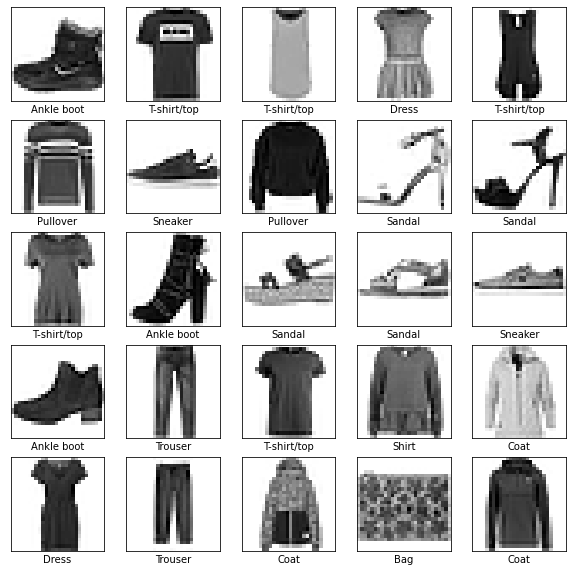

In [9]:
# Give names to classes for clarity
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plot
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

### 2. Define the layers of the model.

In [11]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(154, activation='relu'))
model.add(tf.keras.layers.Dense(154, activation='relu'))
model.add(tf.keras.layers.Dense(154, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

### 3. Compile the model

In [12]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 154)               120890    
_________________________________________________________________
dense_6 (Dense)              (None, 154)               23870     
_________________________________________________________________
dense_7 (Dense)              (None, 154)               23870     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                9920      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                650       
Total params: 179,200
Trainable params: 179,200
Non-trainable params: 0
________________________________________________

In [21]:
! pip3 install pydot
! pip3 install graphviz

In [18]:
! pip freeze

absl-py @ file:///D:/bld/absl-py_1598382479526/work
argon2-cffi @ file:///D:/bld/argon2-cffi_1596630110014/work
arviz @ file:///home/conda/feedstock_root/build_artifacts/arviz_1592923948739/work
astor @ file:///home/conda/feedstock_root/build_artifacts/astor_1593610464257/work
astunparse==1.6.3
atomicwrites @ file:///home/conda/feedstock_root/build_artifacts/atomicwrites_1588182545583/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1599308529326/work
autograd==1.3
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1597679909012/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1588608214987/work
blinker==1.4
blis==0.4.1
bokeh @ file:///D:/bld/bokeh_1599001193669/work
boto==2.49.0
boto3 @ file:///home/conda/feedstock_root/build_artifacts/boto3_1599255782083/work
botocore @ file:///home/conda

In [22]:
tf.keras.utils.plot_model(
    model,
    #to_file='model.png', # if you want to save the image
    show_shapes=True, # True to see more details 
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=150
)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


[Everything you wanted to know about a Keras Model and were afraid to ask](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

### 4. Fit the model to the train set (also using a validation set)

This is the part that takes the longest.

-----------------------------------------------------------
**ep·och** <BR>
noun: epoch; plural noun: epochs. A period of time in history or a person's life, typically one marked by notable events or particular characteristics. Examples: "the Victorian epoch", "my Neural Netwok's epochs". <BR>
    
-----------------------------------------------------------

In [ ]:
%%time
# Fit the model <--- always a good idea to time it! 

history = model.fit(x_train, y_train, validation_split=0.33, epochs=50, 
                    verbose=2)

#### Save the model

You can save the model so you do not have `.fit` everytime you reset the kernel in the notebook. Network training is expensive!

For more details on this see [https://www.tensorflow.org/guide/keras/save_and_serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [ ]:
# save the model so you do not have to run the code everytime
model.save('fashion_model.h5')

# Recreate the exact same model purely from the file
#model = tf.keras.models.load_model('fashion_model.h5')

### 5. Evaluate the model on the test set.

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy={test_accuracy}')

### 6. We learn a lot by studying history: metric traceplots. 

You can learn a lot about neural networks by observing how they perform while training. The networks's performance is stored in a variable named `history` which can be plotted. 

In [ ]:
print(history.history.keys())

In [ ]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

<div class="exercise"><b>What do you observe in these traceplots?</b></div>

## Breakout Room Activity

### 7. Regularization
Let's try adding a regularizer in our model. Name your new model `model_regular`. For more see `tf.keras` [regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers).<BR>

1. Norm penalties: 
    ```
    model_regular.add(tf.keras.layers.Dense(154, activation='relu', 
                                         kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))
    ```
2. Early stopping via `tf.keras.callbacks`. Callbacks provide a way to interact with the model while it's training and inforce some decisions automatically. Callbacks need to be instantiated and are added to the `.fit()` function via the `callbacks` argument.
    ```
    # callbacks: watch validation loss and be "patient" for 10 epochs of no improvement
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=20) 
    model_regular.fit(x_train, y_train, validation_split=0.2, epochs=50, 
                                    verbose=1, callbacks=[es])
    ```
3. Dropout
    ```
    model_regular.add(tf.keras.layers.Dropout(0.2))
    ```
4. Remove layers

#### Note: Name your new model `model_regular` for the rest of the code to work.

In [37]:
# your code here
# define the model
model_regular = tf.keras.Sequential()
model_regular.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model_regular.add(tf.keras.layers.Dense(154, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))
model_regular.add(tf.keras.layers.Dropout(0.2))
model_regular.add(tf.keras.layers.Dense(154, activation='relu'))
# model_regular.add(tf.keras.layers.Dropout(0.2))
model_regular.add(tf.keras.layers.Dense(154, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(l=0.001)))
# model_regular.add(tf.keras.layers.Dropout(0.2))
model_regular.add(tf.keras.layers.Dense(64, activation='relu'))
model_regular.add(tf.keras.layers.Dropout(0.2))
model_regular.add(tf.keras.layers.Dense(10, activation='softmax'))

In [38]:
# compile the model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model_regular.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [39]:
# fit the model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=20) 
history = model_regular.fit(x_train, y_train, validation_split=0.2, epochs=20, 
                    verbose=2, callbacks=[es])

Epoch 1/20
1500/1500 - 6s - loss: 0.8170 - accuracy: 0.7831 - val_loss: 0.5775 - val_accuracy: 0.8454
Epoch 2/20
1500/1500 - 5s - loss: 0.6079 - accuracy: 0.8286 - val_loss: 0.5577 - val_accuracy: 0.8444
Epoch 3/20
1500/1500 - 5s - loss: 0.5659 - accuracy: 0.8357 - val_loss: 0.5356 - val_accuracy: 0.8347
Epoch 4/20
1500/1500 - 5s - loss: 0.5495 - accuracy: 0.8390 - val_loss: 0.5321 - val_accuracy: 0.8399
Epoch 5/20
1500/1500 - 5s - loss: 0.5346 - accuracy: 0.8429 - val_loss: 0.4999 - val_accuracy: 0.8572
Epoch 6/20
1500/1500 - 5s - loss: 0.5271 - accuracy: 0.8441 - val_loss: 0.5402 - val_accuracy: 0.8328
Epoch 7/20
1500/1500 - 5s - loss: 0.5232 - accuracy: 0.8451 - val_loss: 0.5062 - val_accuracy: 0.8446
Epoch 8/20
1500/1500 - 5s - loss: 0.5172 - accuracy: 0.8462 - val_loss: 0.4735 - val_accuracy: 0.8587
Epoch 9/20
1500/1500 - 5s - loss: 0.5071 - accuracy: 0.8497 - val_loss: 0.4847 - val_accuracy: 0.8555
Epoch 10/20
1500/1500 - 5s - loss: 0.5038 - accuracy: 0.8497 - val_loss: 0.4721 - 

In [40]:
# evaluate on test set
test_loss_regular, test_accuracy_regular = model_regular.evaluate(x_test, y_test, verbose=0)
print(test_accuracy_regular)

0.8452000021934509


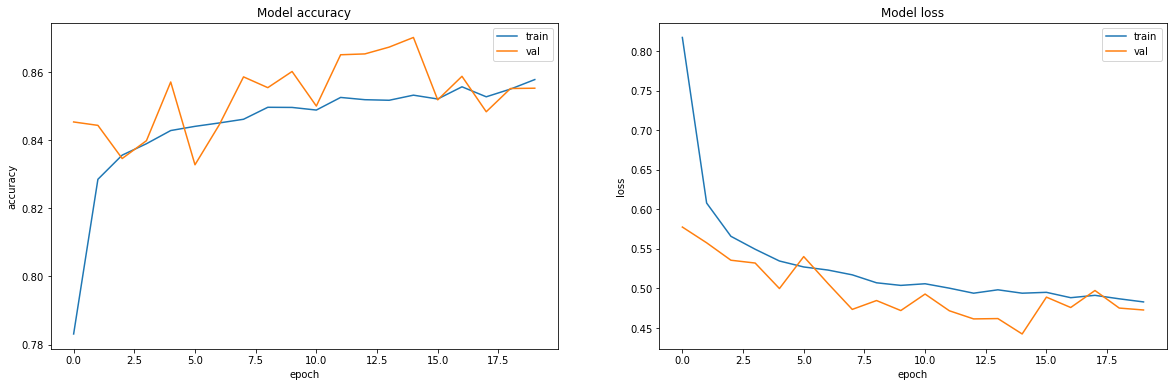

In [41]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='best')

<div class="exercise"><b>In class discussion : How far did you get with regularization?</b></div>

### 7. Now let's predict in the test set

In [ ]:
predictions = model_regular.predict(x_test)

In [ ]:
# choose a specific item to predict (one out of the 60000 samples)
item = 6

In [ ]:
predictions[item]

In [ ]:
np.argmax(predictions[item]), class_names[np.argmax(predictions[item])]

Let's see if our network predicted right! Is the first item what was predicted?

In [ ]:
plt.figure()
plt.imshow(x_test[item], cmap=plt.cm.binary)
plt.xlabel(class_names[y_test[item]])
plt.colorbar()

In [ ]:
# code source: https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [ ]:
i = item
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

### 8. Try our model on a sandal from the Kanye West collection!
The true usefullness of a NN is to be able to classigy unseen data and not only on the test set. Let's see if our network can generalize beyond the MNIST fashion dataset. Let's give it a trendy shoe and see what it predicts. This image is not part of the test set, it was downloaded from the internet. 

<img src="kanye_shoe.jpg" alt="shoe" width="150" height="150"><BR>
<div class="exercise"><b>In class discussion : What kinds of images can our model predict?</b></div>

Bias measures how much the network's output, averaged over all possible data sets differs from the true function. Variance measures how much the network output varies between datasets. Is generalization the pillar of Intelligence?

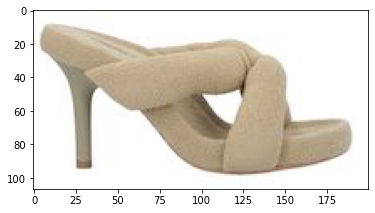

In [5]:
# Let'see the tensor shape
shoe = Image.open('kanye_shoe.jpg')
imgplot = plt.imshow(shoe)

In [ ]:
# Resize image to 28x28
shoe = shoe.resize((28, 28))
imgplot = plt.imshow(shoe)

In [ ]:
shoe = ImageOps.mirror(shoe)
imgplot = plt.imshow(shoe)

In [ ]:
# Delete the other 2 channels to make image B&W. 
shoe_data = np.array(shoe) # cast into munpy array
shoe_data = shoe_data[:,:,0]
print(shoe_data.shape)
imgplot = plt.imshow(shoe_data, cmap=plt.cm.binary)

`tf.keras` models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [ ]:
# Add the image to a batch where it's the only member.
shoe_batch = (np.expand_dims(shoe_data,0))
print(shoe_batch.shape)

In [ ]:
predictions_single = model_regular.predict(shoe_batch)
print(predictions_single[0])
print(np.argmax(predictions_single[0]), class_names[np.argmax(predictions_single[0])])

In [ ]:
shoe_data = np.ones(shoe_data.shape) * 255 - shoe_data
plt.figure()
plt.imshow(shoe_data, cmap=plt.cm.binary)
plt.xlabel('a cool shoe')
plt.colorbar()

In [ ]:
# Add the image to a batch where it's the only member.
shoe_batch = (np.expand_dims(shoe_data,0))
print(shoe_batch.shape)

In [ ]:
predictions_single = model_regular.predict(shoe_batch)
print(predictions_single[0])
print(np.argmax(predictions_single[0]), class_names[np.argmax(predictions_single[0])])

### Data augementation

Data augmentation generates more training data by applying a series of random transformations that yield belivable images. Be careful of transformations that result in unlikely images.

In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
shoe_augm = (np.expand_dims(shoe_data,0))
shoe_augm = (np.expand_dims(shoe_augm, 3))
print(shoe_augm.shape)

In [ ]:
img = shoe_augm
img.shape

In [ ]:
from keras.preprocessing import image

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory (this directory must exist)
i = 0
        
for batch in datagen.flow(shoe_augm, batch_size=1,
                          save_to_dir='preview', save_prefix='shoe', save_format='jpeg'):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]), cmap=plt.cm.binary)
    i += 1
    if i % 6 == 0:
        break # otherwise the generator would loop indefinitely

plt.show()